In [10]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

In [11]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

2022-11-30 22:14:45.915392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 22:14:45.915601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 22:14:45.915742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 22:14:45.915953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 22:14:45.916079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

True

# Evaluation Metric:

Accuracy:
Because the classes in our dataset are balanced, and there is no added benefit (from a buisness perspective) for our model to better predict one of the classes than the others, Accuracy is a good metric to use to judge our models 

## Loading in the Data:

In [12]:
files = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5", "test_batch"]
dir = "cifar-10-batches-py/"

# Loading the data into a single numpy array:
for file in files:
    with open(dir + file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        if file == "data_batch_1":
            data = dict[b'data']
            labels = dict[b'labels']
        else:
            data = np.vstack((data, dict[b'data']))
            labels = np.hstack((labels, dict[b'labels']))



data = data.reshape((data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1).astype("int")

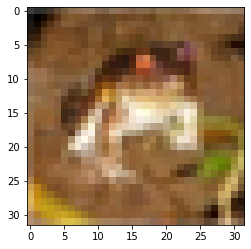

In [13]:
# plot the first image of cifar 10 dataset:
plt.imshow(data[0], interpolation='nearest')

# Splitting the Data:

We will use a stratified train test split. We have enough data, 60,000 images equally split amoungst 10 classes. Therefore, we do not need to use K-fold cross validation or shuffle split in order to properly train and evaluate our models.


In [14]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=69, stratify=labels)

# Modeling

In [15]:
def plot_history(history):
    # plot history of the model:
    fig = plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validate')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')

## Model 1:

In [27]:
datagen = ImageDataGenerator()
datagen.fit(X_train)
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)
dense = tf.keras.layers.Dense(16, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)
model1 = tf.keras.Model(inputs=input, outputs=output)

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(datagen.flow(X_train, y_train, batch_size=256), epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
188/188 [==============================] - 3s 13ms/step - loss: 1.9405 - accuracy: 0.2662 - val_loss: 1.7244 - val_accuracy: 0.3449
Epoch 2/20
188/188 [==============================] - 2s 11ms/step - loss: 1.5781 - accuracy: 0.3936 - val_loss: 1.4843 - val_accuracy: 0.4502
Epoch 3/20
188/188 [==============================] - 2s 11ms/step - loss: 1.4068 - accuracy: 0.4814 - val_loss: 1.3913 - val_accuracy: 0.4933
Epoch 4/20
188/188 [==============================] - 2s 11ms/step - loss: 1.3003 - accuracy: 0.5264 - val_loss: 1.2997 - val_accuracy: 0.5223
Epoch 5/20
188/188 [==============================] - 2s 11ms/step - loss: 1.2260 - accuracy: 0.5541 - val_loss: 1.2366 - val_accuracy: 0.5418
Epoch 6/20
188/188 [==============================] - 2s 11ms/step - loss: 1.1628 - accuracy: 0.5795 - val_loss: 1.2508 - val_accuracy: 0.5413
Epoch 7/20
188/188 [==============================] - 2s 11ms/step - loss: 1.1176 - accuracy: 0.5944 - val_loss: 1.1709 - val_accuracy: 0.5735

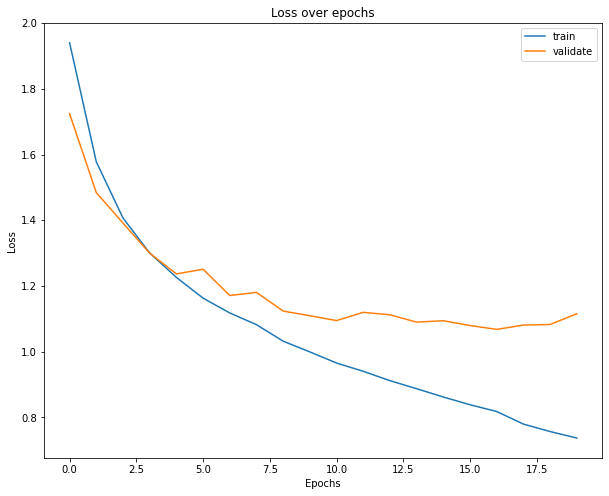

In [28]:
# plot the accuracy and loss of the model:
plot_history(history1)

As seen by the diverging train and validation loss graphs, the model is overfitting and validation accuracy is maxing out at around 62% while the training accuracy peaks at around 74%. In order to combat this we will add dropout in the next model to prevent overfitting.

## Model 1.5

In [47]:
datagen = ImageDataGenerator(rotation_range=5)
datagen.fit(X_train)
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)
dense = tf.keras.layers.Dense(16, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)
model1_5 = tf.keras.Model(inputs=input, outputs=output)

model1_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history1_5 = model1_5.fit(datagen.flow(X_train, y_train, batch_size=256), epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
188/188 [==============================] - 9s 48ms/step - loss: 2.0391 - accuracy: 0.2162 - val_loss: 1.7985 - val_accuracy: 0.3396
Epoch 2/30
188/188 [==============================] - 8s 45ms/step - loss: 1.6716 - accuracy: 0.3772 - val_loss: 1.5712 - val_accuracy: 0.4506
Epoch 3/30
188/188 [==============================] - 9s 45ms/step - loss: 1.5181 - accuracy: 0.4423 - val_loss: 1.4098 - val_accuracy: 0.5057
Epoch 4/30
188/188 [==============================] - 9s 46ms/step - loss: 1.4266 - accuracy: 0.4762 - val_loss: 1.3259 - val_accuracy: 0.5306
Epoch 5/30
188/188 [==============================] - 8s 45ms/step - loss: 1.3615 - accuracy: 0.5032 - val_loss: 1.2753 - val_accuracy: 0.5477
Epoch 6/30
188/188 [==============================] - 8s 45ms/step - loss: 1.3155 - accuracy: 0.5214 - val_loss: 1.2388 - val_accuracy: 0.5641
Epoch 7/30
188/188 [==============================] - 8s 45ms/step - loss: 1.2716 - accuracy: 0.5410 - val_loss: 1.2095 - val_accuracy: 0.5788

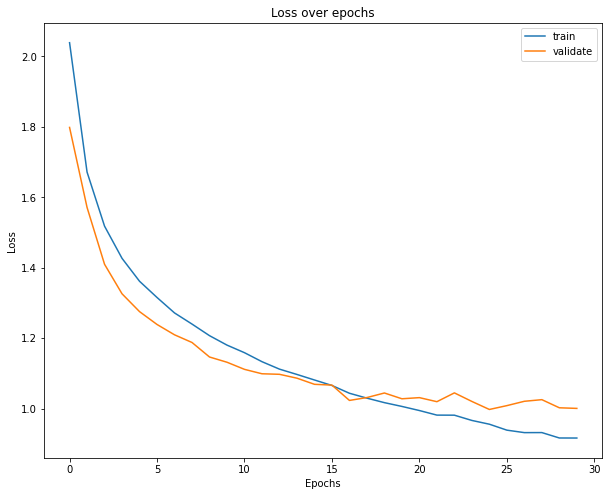

In [49]:
plot_history(history1_5)

## Model 2:

In [13]:
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)

dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

model2 = tf.keras.Model(inputs=input, outputs=output)

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

with tf.device('/cpu:0'):
    history2 = model2.fit(datagen.flow(X_train, y_train, batch_size=1024), epochs=35, validation_data=(X_val, y_val))

Epoch 1/35


2022-11-29 21:05:57.586505: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:417 : INVALID_ARGUMENT: Trying to access resource Resource-343-at-0x2676c630 (defined @ /users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/base_layer_utils.py:134) located in device /job:localhost/replica:0/task:0/device:GPU:0 from device /job:localhost/replica:0/task:0/device:CPU:0
 Cf. https://www.tensorflow.org/xla/known_issues#tfvariable_on_a_different_device
2022-11-29 21:05:57.586581: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:417 : INVALID_ARGUMENT: Trying to access resource Resource-342-at-0x26770330 (defined @ /users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/base_layer_utils.py:134) located in device /job:localhost/replica:0/task:0/device:GPU:0 from device /job:localhost/replica:0/task:0/device:CPU:0
 Cf. https://www.tensorflow.org/xla/known_issues#tfvariable_on_a_different_device
20

2022-11-29 21:05:58.392559: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:417 : INVALID_ARGUMENT: Trying to access resource Resource-324-at-0x26368700 (defined @ /users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/base_layer_utils.py:134) located in device /job:localhost/replica:0/task:0/device:GPU:0 from device /job:localhost/replica:0/task:0/device:CPU:0
 Cf. https://www.tensorflow.org/xla/known_issues#tfvariable_on_a_different_device
2022-11-29 21:05:58.476801: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:417 : INVALID_ARGUMENT: Trying to access resource Resource-315-at-0x2632bf30 (defined @ /users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/base_layer_utils.py:134) located in device /job:localhost/replica:0/task:0/device:GPU:0 from device /job:localhost/replica:0/task:0/device:CPU:0
 Cf. https://www.tensorflow.org/xla/known_issues#tfvariable_on_a_different_device
20

InvalidArgumentError: Graph execution error:

Detected at node 'StatefulPartitionedCall_29' defined at (most recent call last):
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_34764/3349357745.py", line 35, in <module>
      history2 = model2.fit(datagen.flow(X_train, y_train, batch_size=1024), epochs=35, validation_data=(X_val, y_val))
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_29'
Detected at node 'StatefulPartitionedCall_29' defined at (most recent call last):
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_34764/3349357745.py", line 35, in <module>
      history2 = model2.fit(datagen.flow(X_train, y_train, batch_size=1024), epochs=35, validation_data=(X_val, y_val))
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_29'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Trying to access resource Resource-343-at-0x2676c630 (defined @ /users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/base_layer_utils.py:134) located in device /job:localhost/replica:0/task:0/device:GPU:0 from device /job:localhost/replica:0/task:0/device:CPU:0
 Cf. https://www.tensorflow.org/xla/known_issues#tfvariable_on_a_different_device
	 [[{{node StatefulPartitionedCall_29}}]]
	 [[GroupCrossDeviceControlEdges_0/AssignAddVariableOp_2/_295]]
  (1) INVALID_ARGUMENT:  Trying to access resource Resource-343-at-0x2676c630 (defined @ /users/skoka/.conda/envs/ml_env_2/lib/python3.10/site-packages/keras/engine/base_layer_utils.py:134) located in device /job:localhost/replica:0/task:0/device:GPU:0 from device /job:localhost/replica:0/task:0/device:CPU:0
 Cf. https://www.tensorflow.org/xla/known_issues#tfvariable_on_a_different_device
	 [[{{node StatefulPartitionedCall_29}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_84147]

In [11]:
model2.save('model2.h5')

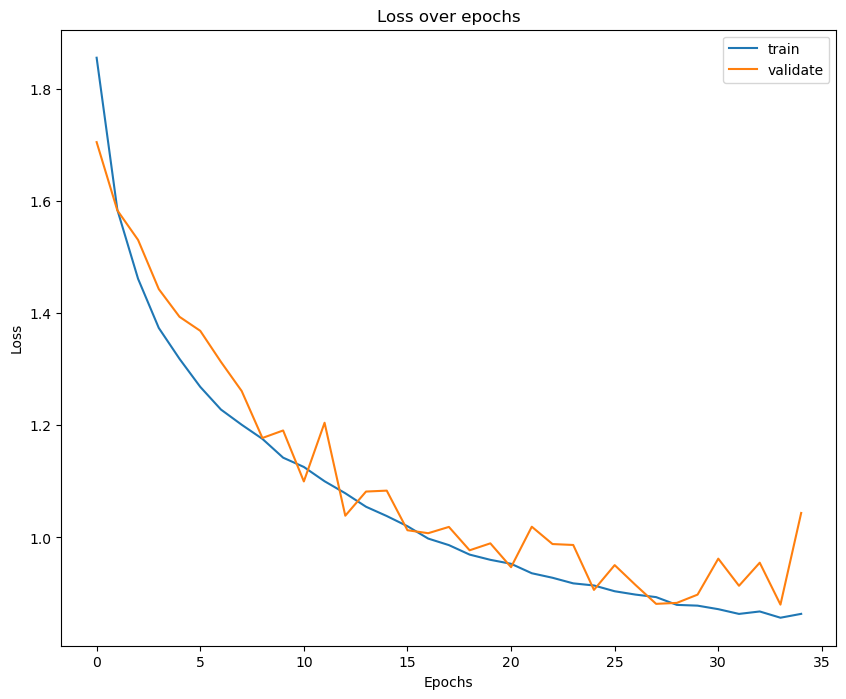

In [13]:
plot_history(history2)

## Model 3:


In [22]:
from tensorflow.keras.regularizers import l2

input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(.0001))(normalized_input)
x = tf.keras.layers.BatchNormalization()(x)
x_save = tf.keras.layers.Dropout(0.4)(x)

# 1st block
x = tf.keras.layers.Conv2D(64, (1, 1), activation='relu', padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(.0001))(x_save)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(.0001))(x)
x = tf.keras.layers.Conv2D(256, (1, 1), activation='relu', padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(.0001))(x)

# Adding two layers
x_save = tf.keras.layers.Add()([x, x_save])

# 2nd block
x = tf.keras.layers.Conv2D(64, (1, 1), activation='relu', padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(.0001))(x_save)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(.0001))(x)
x = tf.keras.layers.Conv2D(256, (1, 1), activation='relu', padding="same", kernel_initializer="he_uniform", kernel_regularizer=l2(.0001))(x)

# Adding two layers
x = tf.keras.layers.Add()([x, x_save])

# Max pooling
max_pool = tf.keras.layers.MaxPooling2D((2, 2))(x_save)

# dense layers
dense = tf.keras.layers.Flatten()(max_pool)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

model3 = tf.keras.Model(inputs=input, outputs=output)

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_7 (Rescaling)        (None, 32, 32, 3)    0           ['input_8[0][0]']                
                                                                                                  
 conv2d_51 (Conv2D)             (None, 32, 32, 256)  7168        ['rescaling_7[0][0]']            
                                                                                                  
 batch_normalization_18 (BatchN  (None, 32, 32, 256)  1024       ['conv2d_51[0][0]']              
 ormalization)                                                                              

In [ ]:
# Train the model

history3 = model3.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


2022-11-29 21:28:52.416478: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_26/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1500/1500 [==============================] - 13s 7ms/step - loss: 2.9703 - accuracy: 0.1519 - val_loss: 6.6824 - val_accuracy: 0.1656
Epoch 2/20
1500/1500 [==============================] - 11s 7ms/step - loss: 2.1072 - accuracy: 0.1965 - val_loss: 3.7241 - val_accuracy: 0.1654
Epoch 3/20
1500/1500 [==============================] - 10s 7ms/step - loss: 1.9799 - accuracy: 0.2119 - val_loss: 2.8199 - val_accuracy: 0.2115
Epoch 4/20
1500/1500 [==============================] - 11s 7ms/step - loss: 1.9160 - accuracy: 0.2217 - val_loss: 2.3801 - val_accuracy: 0.2325
Epoch 5/20
1500/1500 [==============================] - 11s 7ms/step - loss: 1.8709 - accuracy: 0.2307 - val_loss: 2.7768 - val_accuracy: 0.2705
Epoch 6/20
1500/1500 [==============================] - 11s 7ms/step - loss: 1.8383 - accuracy: 0.2412 - val_loss: 3.2691 - val_accuracy: 0.2801
Epoch 7/20
1500/1500 [==============================] - 10s 7ms/step - loss: 1.8100 - accuracy: 0.2530 - val_loss: 3.9634 - val_accuracy: 0.2

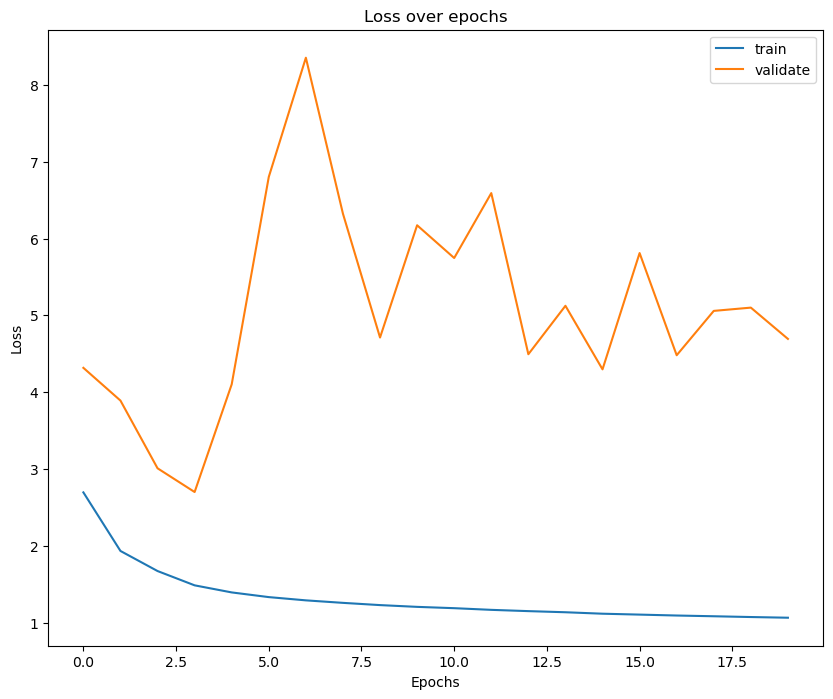

In [21]:
plot_history(history3)

In [ ]:
model3.save('model3.h5')